In [27]:
import os
import sys
from importlib import reload
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
        
from time import time 
import pickle

import numpy as np
import scipy as sc
import pandas as pd
import editdistance

import torch
from sklearn.isotonic import IsotonicRegression

import rna
import utils
import models

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
# def get_gmm_data(p0, mu0, mu1, n):
#     bin_n = sc.stats.bernoulli.rvs(p0, loc=0, size=n)
#     n0_n = sc.stats.norm.rvs(loc=mu0, scale=1, size=n)
#     n1_n = sc.stats.norm.rvs(loc=mu1, scale=1, size=n)
#     return bin_n * n0_n + (1 - bin_n) * n1_n

# # example usage
# y = get_gmm_data(0.05, 0, 5, 10000)
# threshold = otsu_threshold(y)
# print(f"optimal threshold is: {threshold}")
# plt.hist(y, bins=20);
# plt.axvline(threshold);

In [2]:
# load labeled data
reload(models)
train_fname = '/data/wongfanc/rna-models/traindata-n10000-nsd0.02-h100-092324.npz'
d = np.load(train_fname)
trainseq_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']

# fit ridge regression
ridge = models.RidgeRegressor(seq_len=50, alphabet=utils.RNA_NUCLEOTIDES)
ridge.fit(trainseq_n, ytrain_n)

# load trained FF and CNN models
ff_fname = '/data/wongfanc/rna-models/ff-n10000-nsd0.02-h100-092324.pt'
ff = models.FeedForward(50, utils.RNA_NUCLEOTIDES, 100)
ff.load(ff_fname)

cnn_fname = '/data/wongfanc/rna-models/cnn-n10000-nsd0.02-h100-092324.pt'
cnn = models.CNN(50, utils.RNA_NUCLEOTIDES, 32, 100)
cnn.load(cnn_fname)

In [3]:
# load 10k-model designs
# does not contain any DbAS ridge with Q > 0.2 or Biswas temp over 0.02
design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-0.pkl'

with open(design_pkl_fname, 'rb') as f:
    name2designdata = pickle.load(f)
for name in name2designdata:
    print(name)

cbas-ridge-0.1t19
cbas-ridge-0.2t19
cbas-ridge-0.3t19
cbas-ridge-0.4t19
cbas-ridge-0.5t19
cbas-ridge-0.6t19
cbas-ridge-0.7t19
cbas-ridge-0.8t19
cbas-ridge-0.9t19
dbas-ridge-0.1t19
dbas-ridge-0.2t19
dbas-ff-0.1
dbas-ff-0.2
dbas-ff-0.3
dbas-ff-0.4
dbas-ff-0.5
dbas-ff-0.6
dbas-ff-0.7
dbas-ff-0.8
dbas-ff-0.9
dbas-cnn-0.1
dbas-cnn-0.2
dbas-cnn-0.3
dbas-cnn-0.4
dbas-cnn-0.5
dbas-cnn-0.6
dbas-cnn-0.7
dbas-cnn-0.8
dbas-cnn-0.9
adalead-ridge-0.5
adalead-ridge-0.45
adalead-ridge-0.4
adalead-ridge-0.35
adalead-ridge-0.3
adalead-ridge-0.25
adalead-ridge-0.2
adalead-ridge-0.15
adalead-ridge-0.1
adalead-ridge-0.05
adalead-ridge-0.01
biswas-ridge-0.02
biswas-ridge-0.015
biswas-ridge-0.01
biswas-ridge-0.005
pex-ridge
adalead-ff-0.5
adalead-ff-0.45
adalead-ff-0.4
adalead-ff-0.35
adalead-ff-0.3
adalead-ff-0.25
adalead-ff-0.2
adalead-ff-0.15
adalead-ff-0.1
adalead-ff-0.05
adalead-ff-0.01
biswas-ff-0.02
biswas-ff-0.015
biswas-ff-0.01
biswas-ff-0.005
pex-ff
adalead-cnn-0.5
adalead-cnn-0.45
adalead-cnn-0.4


In [19]:
# ----- build menu of design algorithm names -----
adalead_thresholds = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

design_names = ['vae-ridge']
    
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    design_names.append(f'dbas-ridge-{q}')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    design_names.append(f'pex-{model_name}') 
    
    # CbAS
    for q in cbas_dbas_quantiles:
        q = round(q, 2)
        design_names.append(f'cbas-{model_name}-{q}')
        
    # dbas
    if model_name != 'ridge':
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')

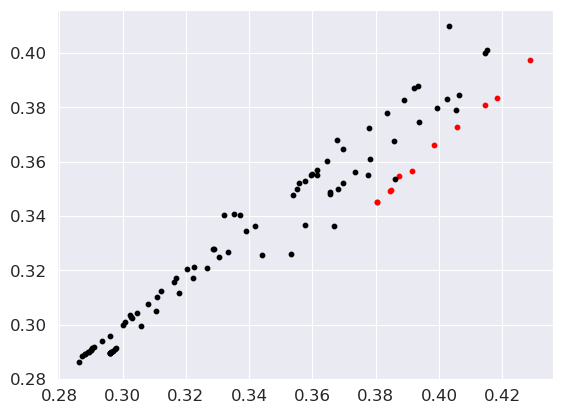

In [24]:
for name in design_names:
    if 'adalead' in name and 'ridge' in name:
        color = 'red'
    else:
        color ='k'
    plt.scatter(np.mean(name2designdata[name][2]), np.mean(name2designdata[name][1]), c= color, s=10)

In [16]:
# arrange predictions for designs
name = 'biswas-ridge-0.005'

designseq_N, ydesign_N, _ = name2designdata[name]
designpred_Nxm = np.hstack([
    ridge.predict(designseq_N)[:, None],
    ff.ensemble_predict(designseq_N),
    cnn.ensemble_predict(designseq_N)
])
trainpred_nxm = np.hstack([
    ridge.predict(trainseq_n)[:, None],
    ff.ensemble_predict(trainseq_n),
    cnn.ensemble_predict(trainseq_n)
])

q = 0.0. PO: 0.39, true: 0.38, forecast: 0.38


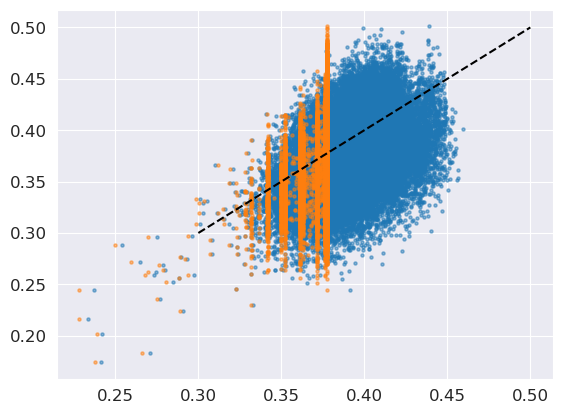

In [17]:
q = 0.

designp_N, designmuplus_N, designmuneg_N, designsigplus_N, designsigneg_N = wheelock_posterior(
    trainseq_n, ytrain_n, trainpred_nxm, designseq_N, designpred_Nxm,
    q=q
)

designmean_N = designp_N * designmuplus_N + (1 - designp_N) * designmuneg_N

plt.scatter(np.mean(designpred_Nxm, axis=1), ydesign_N, alpha=0.5, s=5);
plt.scatter(designmean_N, ydesign_N, alpha=0.5, s=5);
plt.plot([0.3, 0.5], [0.3, 0.5], '--k');

print('q = {}. PO: {:.2f}, true: {:.2f}, forecast: {:.2f}'.format(
    q, np.mean(designpred_Nxm), np.mean(ydesign_N), np.mean(designmean_N)
))

In [53]:
reload(rna)

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

design_names = ['vae-ridge']
    
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    design_names.append(f'dbas-ridge-{q}')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    design_names.append(f'pex-{model_name}') 
    
    # CbAS
    for q in cbas_dbas_quantiles:
        q = round(q, 2)
        design_names.append(f'cbas-{model_name}-{q}')
        
    # dbas
    if model_name != 'ridge':
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')
            
print(f'Testing {len(design_names)} design names:')
for name in design_names:
    print(f'  {name}')
    

n_trial = 10
design_pkl_fname_no_trial = '/data/wongfanc/rna-results/designs-n10k-092324'
model_and_data_fname_no_ftype = 'n10000-nsd0.02-h100-092324'
target_values = np.arange(0.25, 0.501, 0.001)
qs = np.array([0, 0.5, 1.])
imp_csv_fname = '/data/wongfanc/rna-results/selection-imputation-ped-111424.csv'
wheelock_csv_fname = '/data/wongfanc/rna-results/selection-wheelock-ped-111424.csv'

df, wf_df, name2truemeans = rna.run_imputation_selection_experiments(
    design_names,
    n_trial=n_trial,
    wheelock_forecast_qs=qs,
    design_pkl_fname_no_trial=design_pkl_fname_no_trial,
    model_and_data_fname_no_ftype=model_and_data_fname_no_ftype,
    target_values=target_values,
    imp_csv_fname=imp_csv_fname,
    wheelock_csv_fname=wheelock_csv_fname
)

Testing 96 design names:
  vae-ridge
  dbas-ridge-0.1
  dbas-ridge-0.2
  adalead-ridge-0.5
  adalead-ridge-0.45
  adalead-ridge-0.4
  adalead-ridge-0.35
  adalead-ridge-0.3
  adalead-ridge-0.25
  adalead-ridge-0.2
  adalead-ridge-0.15
  adalead-ridge-0.1
  adalead-ridge-0.05
  adalead-ridge-0.01
  biswas-ridge-0.02
  biswas-ridge-0.015
  biswas-ridge-0.01
  biswas-ridge-0.005
  pex-ridge
  cbas-ridge-0.1
  cbas-ridge-0.2
  cbas-ridge-0.3
  cbas-ridge-0.4
  cbas-ridge-0.5
  cbas-ridge-0.6
  cbas-ridge-0.7
  cbas-ridge-0.8
  cbas-ridge-0.9
  adalead-ff-0.5
  adalead-ff-0.45
  adalead-ff-0.4
  adalead-ff-0.35
  adalead-ff-0.3
  adalead-ff-0.25
  adalead-ff-0.2
  adalead-ff-0.15
  adalead-ff-0.1
  adalead-ff-0.05
  adalead-ff-0.01
  biswas-ff-0.02
  biswas-ff-0.015
  biswas-ff-0.01
  biswas-ff-0.005
  pex-ff
  cbas-ff-0.1
  cbas-ff-0.2
  cbas-ff-0.3
  cbas-ff-0.4
  cbas-ff-0.5
  cbas-ff-0.6
  cbas-ff-0.7
  cbas-ff-0.8
  cbas-ff-0.9
  dbas-ff-0.1
  dbas-ff-0.2
  dbas-ff-0.3
  dbas-ff-0.4
  

No design data for cbas-ridge-0.1t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.1t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.2t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.2t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.3t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.3t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.4t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.4t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.5t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.5t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.6t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.6t0, exiting MDRE select_intermediate_iterations.
No design data f

In [58]:
wf_df.head()

,wf_mean_q0.00_vae-ridge,wf_mean_q0.00_dbas-ridge-0.1,wf_mean_q0.00_dbas-ridge-0.2,wf_mean_q0.00_adalead-ridge-0.5,wf_mean_q0.00_adalead-ridge-0.45,wf_mean_q0.00_adalead-ridge-0.4,wf_mean_q0.00_adalead-ridge-0.35,wf_mean_q0.00_adalead-ridge-0.3,wf_mean_q0.00_adalead-ridge-0.25,wf_mean_q0.00_adalead-ridge-0.2,...,wf_mean_q1.00_cs_cbas-cnn-0.9,wf_mean_q1.00_cs_dbas-cnn-0.1,wf_mean_q1.00_cs_dbas-cnn-0.2,wf_mean_q1.00_cs_dbas-cnn-0.3,wf_mean_q1.00_cs_dbas-cnn-0.4,wf_mean_q1.00_cs_dbas-cnn-0.5,wf_mean_q1.00_cs_dbas-cnn-0.6,wf_mean_q1.00_cs_dbas-cnn-0.7,wf_mean_q1.00_cs_dbas-cnn-0.8,wf_mean_q1.00_cs_dbas-cnn-0.9
0,0.286325,0.304575,0.359515,0.370388,0.370076,0.372537,0.373058,0.374457,0.376857,0.380184,...,0.283731,0.293185,0.298252,0.321383,0.314692,0.305632,0.310147,0.342472,0.339938,0.327233
1,0.286654,0.343816,0.374333,0.370513,0.370095,0.370892,0.371512,0.374432,0.376055,0.379819,...,0.284823,0.301698,0.291138,0.304597,0.310152,0.319857,0.324674,0.311461,0.306215,0.310591
2,0.287146,0.323102,0.340608,0.369796,0.370677,0.371169,0.372344,0.373649,0.376549,0.380043,...,0.286937,0.305598,0.308708,0.315855,0.294179,0.319785,0.307114,0.312106,0.302274,0.371372
3,0.286209,0.342479,0.378846,0.370544,0.371873,0.372212,0.373026,0.374976,0.377108,0.380124,...,0.285972,0.304872,0.299074,0.295403,0.292082,0.31199,0.311055,0.306435,0.31154,0.308725
4,0.287031,0.313432,0.374356,0.368621,0.370015,0.369512,0.371506,0.373567,0.375968,0.379793,...,0.286619,0.31125,0.309358,0.315414,0.294226,0.301859,0.297952,0.316934,0.307523,0.320487


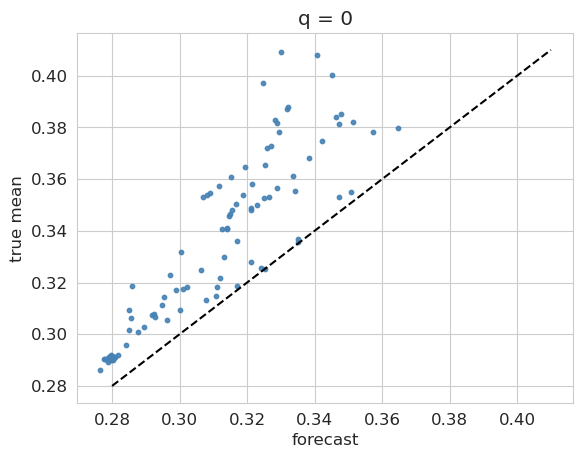

In [57]:
sns.set_style('whitegrid')
trial_idx = 1
q = 0

for name, means in name2truemeans.items():
    forecast = wf_df.loc[trial_idx]['wf_mean_q{:.2f}_cs_{}'.format(q, name)]
    plt.scatter(forecast, np.mean(means), c='steelblue', alpha=0.9, s=10)

plt.plot([0.28, 0.41], [0.28, 0.41], '--k');
plt.xlabel('forecast');
plt.ylabel('true mean');
plt.title('q = {}'.format(q));